In [1]:
import os
import re
from typing import List, Optional
import io 

import click
import dnnlib
import numpy as np
import torch

import legacy

import librosa
import librosa.display
import soundfile as sf

from tifresi.utils import load_signal
from tifresi.utils import preprocess_signal
from tifresi.stft import GaussTF, GaussTruncTF
from tifresi.transforms import log_spectrogram
from tifresi.transforms import inv_log_spectrogram

import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from IPython.display import Audio 
import IPython

import struct

In [2]:
network_pkl = 'training-runs/00041-vis-data-256-split-auto1-noaug/network-snapshot-002200.pkl'

stft_channels = 512
n_frames = 256
hop_size = 128
sample_rate = 16000
        
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G'].to(device).eval()
    
with dnnlib.util.open_url(network_pkl) as f:
    G_ema = legacy.load_network_pkl(f)['G_ema'].to(device).eval()

In [3]:
def pghi_istft(x):
    use_truncated_window = True
    if use_truncated_window:
        stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)
    else:
        stft_system = GaussTF(hop_size=hop_size, stft_channels=stft_channels)

    x = np.squeeze(x,axis=0)
    new_Y = inv_log_spectrogram(x)
    new_y = stft_system.invert_spectrogram(new_Y)
    return new_y

torch.Size([1, 1, 256, 256])
(1, 256, 256)
(1, 1, 256)
(1, 257, 256)


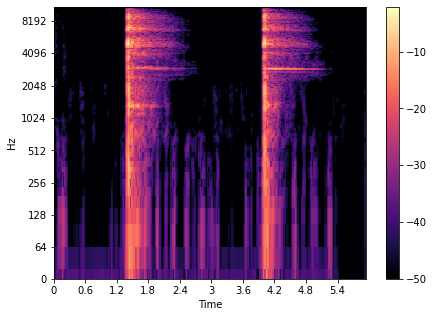

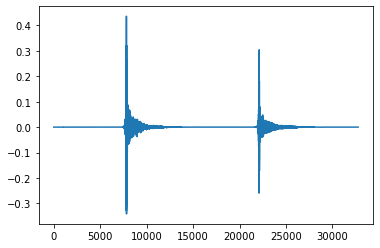

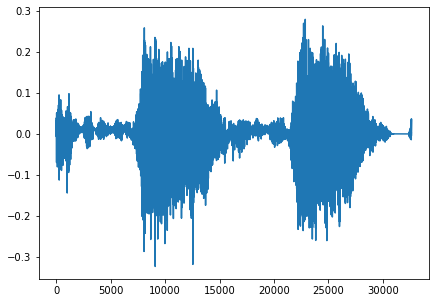

In [12]:
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
label = torch.zeros([1, G_ema.z_dim], device=device)
img = G(z, label)


print(img.shape)

img = (img  * 127.5+ 128).clamp(0, 255).to(torch.uint8)
img = img.detach().cpu().numpy()[0]
print(img.shape)

filler = np.full((1, 1, img[0][0].shape[0]), np.min(img))
print(filler.shape)
img_1 = np.append(img, filler, axis=1) # UNDOING THAT CODE!
print(img_1.shape)
img_1 = img_1/255
img_1 = -50+img_1*50

fig =plt.figure(figsize=(7, 5))
a=librosa.display.specshow(img_1[0],x_axis='time', y_axis='log')
fig.colorbar(a)
io_buf = io.BytesIO()
fig.savefig(io_buf, format='raw')
io_buf.seek(0)
img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                     newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
io_buf.close()


#Using PGHI
audio = pghi_istft(img_1)
fig = plt.figure()
plt.plot(audio)
IPython.display.display(IPython.display.Audio(audio, rate=sample_rate))


#Using Griffin Lim
audio = librosa.core.istft(
                    img_1[0],
                    hop_length=hop_size,
                    win_length=stft_channels)
plt.figure(figsize=(7,5))
plt.plot(audio)
IPython.display.display(IPython.display.Audio(audio, rate=sample_rate))



# What does the Average Style look like?

torch.Size([1, 1, 256, 256])
(1, 256, 256)
(1, 1, 256)
(1, 257, 256)


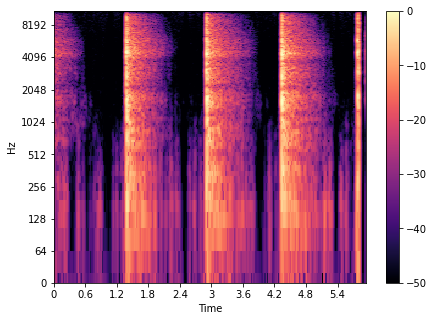

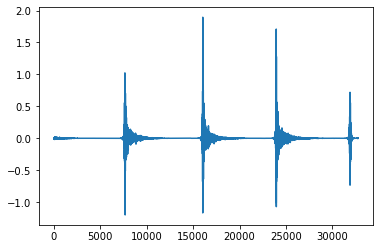

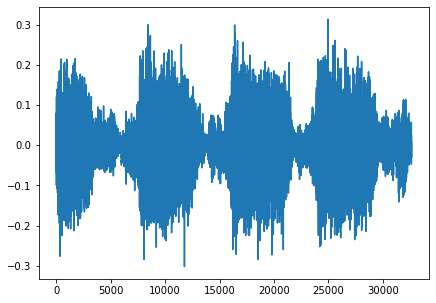

In [13]:

w_avg = G.mapping.w_avg
w =  w_avg.repeat(1, 14, 1)# + (w - w_avg) *0.0 #truncation_psi


img = G.synthesis(w, noise_mode='const')


print(img.shape)

img = (img  * 127.5+ 128).clamp(0, 255).to(torch.uint8)
img = img.detach().cpu().numpy()[0]
print(img.shape)

filler = np.full((1, 1, img[0][0].shape[0]), np.min(img))
print(filler.shape)
img_1 = np.append(img, filler, axis=1) # UNDOING THAT CODE!
print(img_1.shape)
img_1 = img_1/255
img_1 = -50+img_1*50

fig =plt.figure(figsize=(7, 5))
a=librosa.display.specshow(img_1[0],x_axis='time', y_axis='log')
fig.colorbar(a)
io_buf = io.BytesIO()
fig.savefig(io_buf, format='raw')
io_buf.seek(0)
img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                     newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
io_buf.close()



audio = pghi_istft(img_1)
fig = plt.figure()
plt.plot(audio)
IPython.display.display(IPython.display.Audio(audio, rate=sample_rate))



audio = librosa.core.istft(
                    img_1[0],
                    hop_length=hop_size,
                    win_length=stft_channels)
plt.figure(figsize=(7,5))
plt.plot(audio)
IPython.display.display(IPython.display.Audio(audio, rate=sample_rate))

